In [584]:
import os
import sys
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
from torchvision import transforms

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import shap

In [708]:
train_set = pd.read_csv("heart_failure/train_val_split.csv")
test_set = pd.read_csv("heart_failure/test_split.csv")

# 1. Exploratory Data Analysis 

In [3]:
train_set.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [4]:
test_set.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,60,M,ASY,145,282,0,LVH,142,Y,2.8,Flat,1
1,57,M,ASY,160,0,1,Normal,98,Y,2.0,Flat,1
2,62,F,ASY,150,244,0,Normal,154,Y,1.4,Flat,1
3,59,M,ASY,164,176,1,LVH,90,N,1.0,Flat,1
4,57,M,ASY,128,0,1,ST,148,Y,1.0,Flat,1


In [733]:
y_train = train_set.HeartDisease.values
X_train = train_set.drop('HeartDisease', axis=1)
y_test = test_set.HeartDisease.values
X_test = test_set.drop('HeartDisease', axis=1)

__Checking column types and set sizes__

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 63.2+ KB


In [65]:
print(X_train.shape, X_test.shape)

(734, 11) (184, 11)


__Checking for missing values:__

In [31]:
X_train.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
dtype: int64

No Nan values. 

__Feature meaning :__ 
- ChestPainType : TA : Typical Angina ; ATA : Atypical Angina; ASY : Asymptonic ; NAP : Non-Anginal Pain
- RestingBP : Resting Blood Pressure (mmHg), normal: less than 140, 140-200: hypertension
- Cholesterol : serum cholesterol in mm/dl
- FastingBS : Fasting Blood Sugar : 1 if FastingBS > 120 mg/dl 0 otherwise
- RestingECG : Resting Electrocardiogram : Normal, ST: ST-T wave abnormality 
- MaxHR : Maximum heart Rate
- ExerciseAngina : exercise-induced angina: Yes or No
- ST_Slope :the slope of the peak exercise ST segment :  upsloping, flat, downsloping


source : https://rpubs.com/sunartorusli/heart_diseases

### Plotting feature distribution

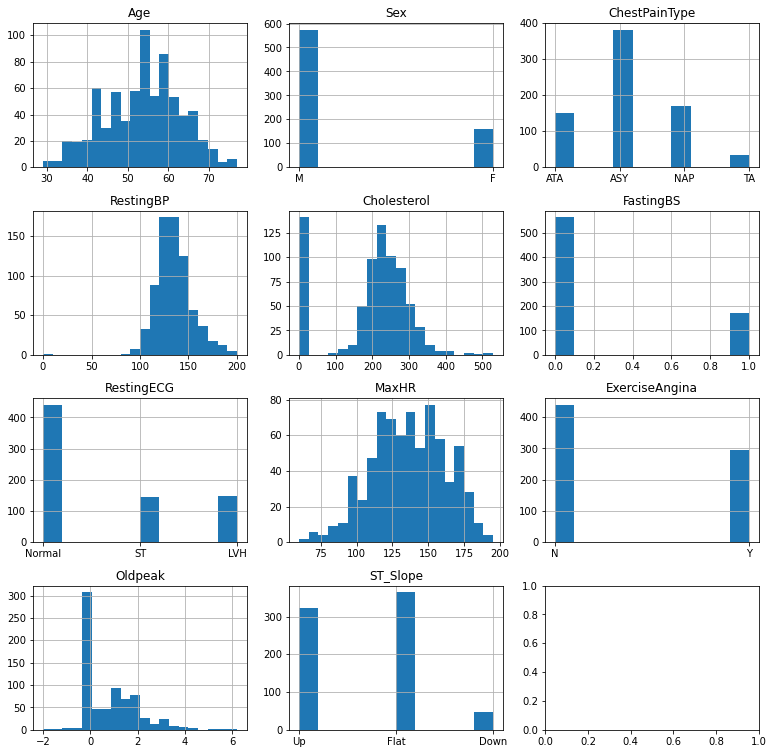

In [668]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(13, 13))
fig.subplots_adjust(hspace=0.3) 


X_train['Age'].hist(ax=axs[0, 0], bins=20)
axs[0, 0].set_title('Age')
X_train['Sex'].hist(ax=axs[0, 1])
axs[0, 1].set_title('Sex')
X_train['ChestPainType'].hist(ax=axs[0, 2])
axs[0, 2].set_title('ChestPainType')
X_train['RestingBP'].hist(ax=axs[1, 0], bins=20)
axs[1, 0].set_title('RestingBP')
X_train['Cholesterol'].hist(ax=axs[1, 1], bins=20)
axs[1, 1].set_title('Cholesterol')
X_train['FastingBS'].hist(ax=axs[1, 2])
axs[1, 2].set_title('FastingBS')
X_train['RestingECG'].hist(ax=axs[2, 0])
axs[2, 0].set_title('RestingECG')
X_train['MaxHR'].hist(ax=axs[2, 1], bins=20)
axs[2, 1].set_title('MaxHR')
X_train['ExerciseAngina'].hist(ax=axs[2, 2])
axs[2, 2].set_title('ExerciseAngina')
X_train['Oldpeak'].hist(ax=axs[3, 0], bins=20)
axs[3, 0].set_title('Oldpeak')
X_train['ST_Slope'].hist(ax=axs[3, 1])
axs[3, 1].set_title('ST_Slope')

plt.show()

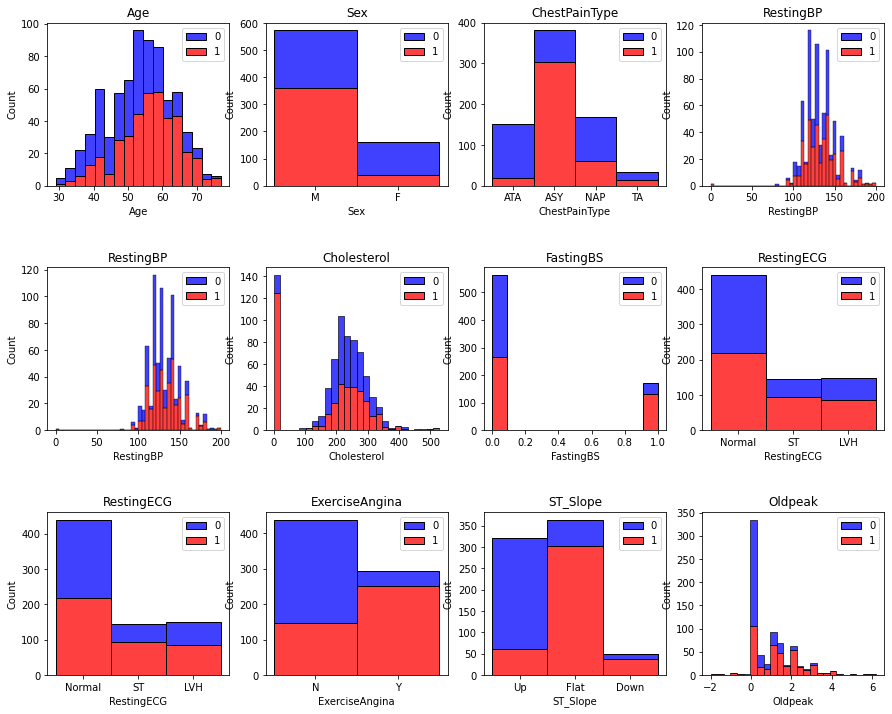

In [671]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))  
fig.subplots_adjust(hspace=0.5)  

feature_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'Oldpeak']  # Replace these with your actual feature names

for i in range(3):  
    for j in range(4): 
        feature = feature_names[i * 3 + j]  
        sns.histplot(data=train_set, x=feature, hue=y_train, multiple="stack", palette=["blue", "red"], ax=axs[i, j])
        axs[i, j].set_title(feature)

<Figure size 720x576 with 0 Axes>

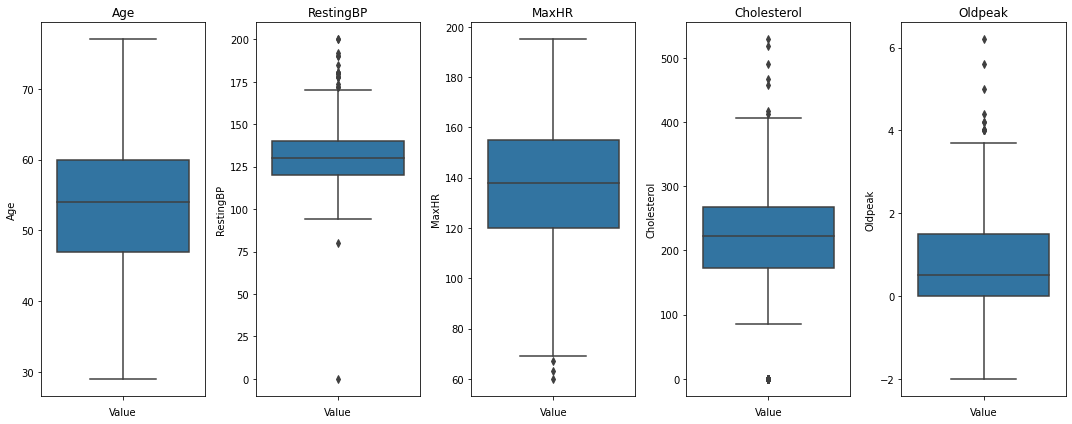

In [672]:
plt.subplots_adjust(hspace=0.2)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))

feature_names=['Age', 'RestingBP','MaxHR', 'Cholesterol','Oldpeak']
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    sns.boxplot(y=X_train[feature], ax=axes[i], orient='v')
    axes[i].set_title(feature)
    axes[i].set_xlabel('Value')
    
plt.tight_layout()
plt.show()

Thanks to the boxplots we can see some outliers, mostly in RestingBP and Cholesterol values.

### Plotting pairwise feature relationships

<AxesSubplot:>

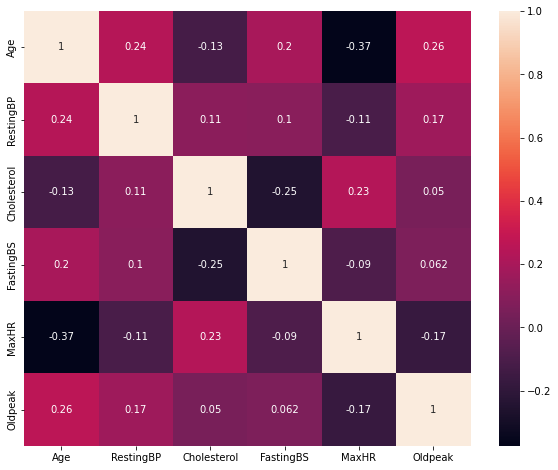

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr(), annot=True)

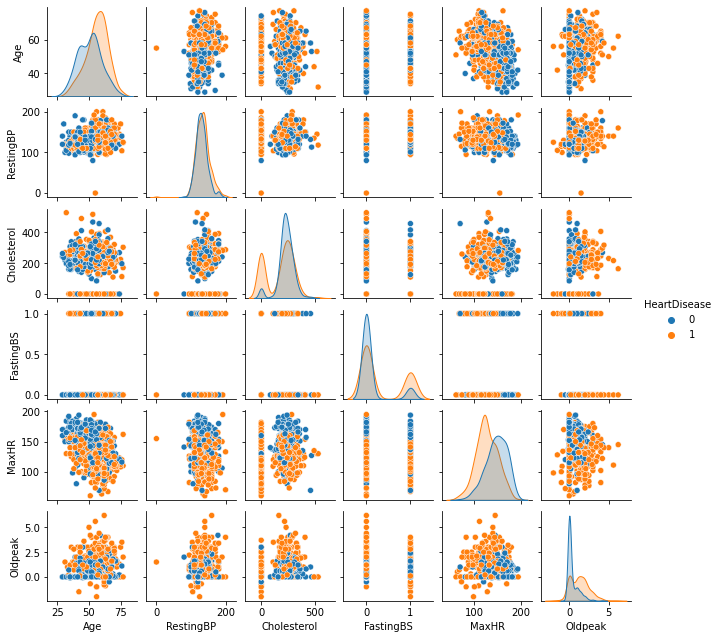

In [40]:
sns.pairplot(train_set, hue="HeartDisease", height=1.5);

Numerical features are not strongly correlated, the highest correlations being between Age and Maximum Heart Rate and between cholesterol and fasting blood sugar.

### Class imbalance

let's observe the ratio of labels (normal vs pneumonia):

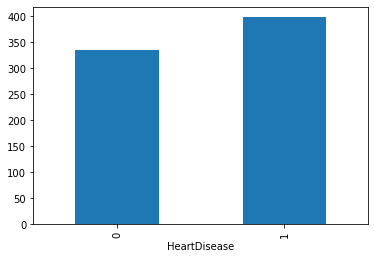

In [50]:
grouped_by_label=train_set.groupby(by='HeartDisease').size()
grouped_by_label.plot(kind='bar')
plt.show()

The class are not perfectly balanced but the difference is small :

In [51]:
grouped_by_label

HeartDisease
0    336
1    398
dtype: int64

In [54]:
abs(grouped_by_label[0] - grouped_by_label[1])

62

Difference is between acceptable range, no need of sampling. 

### Outliers removal based on the interquartile range (IQR) rule

Let's remove the outliers in Resting Blood pressure and Oldpeak first. We don't remove the outliers of cholesterol first as it would remove the zeroes cholesterol that we would like to impute to avoid discarding too many samples. 

In [410]:
def outlier_removal(df, outlier_features):
    df_no_outliers = df.copy()

    # Loop through the features and remove outliers based on the IQR rule
    for feature in outlier_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[feature] >= lower_bound) & (df_no_outliers[feature] <= upper_bound)]
    df_no_outliers = df_no_outliers.reset_index(drop=True)
    
    return df_no_outliers.drop('HeartDisease', axis=1), df_no_outliers['HeartDisease']

<Figure size 720x576 with 0 Axes>

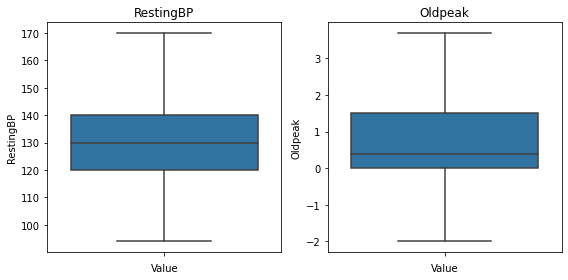

In [749]:
x_train_wo_outliers, y_train_wo_outliers= outlier_removal(train_set, ['RestingBP','Oldpeak'])
plt.subplots_adjust(hspace=0.2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes = axes.flatten()

for i, feature in enumerate(['RestingBP', 'Oldpeak']):
    sns.boxplot(y=train_set_wo_outliers[feature], ax=axes[i], orient='v')
    axes[i].set_title(feature)
    axes[i].set_xlabel('Value')
    
plt.tight_layout()
plt.show()

Now we don't have outliers anymore, and the values taken by RetsingBP and Oldpeak are meaningful, the samples showing zero blood pressure have been removed. 

### Non sensical values: imputing zero cholesterol and blood pressure with mean value

As we observed in the data exploration part, a lot of samples contain zero cholesterol. We don't want to discard them because we would loose a lot of data. Instead we can impute these zeroes. One simplest approach could be to replace the zeroes by the mean value. 

In [6]:
def mean_imputing(X_train,X_test):
    non_zero_cholesterol = pd.concat([X_train['Cholesterol'], X_test['Cholesterol']]).loc[lambda x: x > 0]
    cholesterol_mean_excluding_zeroes = non_zero_cholesterol.mean()

    X_train_chol_imputed= X_train.copy()
    X_test_chol_imputed= X_test.copy()

    X_train_chol_imputed['Cholesterol'] = X_train_chol_imputed['Cholesterol'].replace(0, cholesterol_mean_excluding_zeroes)
    X_test_chol_imputed['Cholesterol'] = X_test_chol_imputed['Cholesterol'].replace(0, cholesterol_mean_excluding_zeroes)

    non_zero_bp = pd.concat([X_train['RestingBP'], X_test['RestingBP']]).loc[lambda x: x > 0]
    bp_mean_excluding_zeroes = non_zero_bp .mean()

    X_train_imputed['RestingBP'] = X_train_chol_imputed['RestingBP'].replace(0, bp_mean_excluding_zeroes)
    X_test_imputed['RestingBP'] = X_test_chol_imputed['RestingBP'].replace(0, bp_mean_excluding_zeroes)
    
    return X_train_imputed, X_test_imputed

However, a better approach would be take the other features values into consideration, by predicting the missing cholesterol values using a linear regression for example. For this we need to encode the categorical features into numerical values. This is the next preprocessing step

### Categorical values conversion: One Hot Encoding

In [736]:
def one_hot_encode(X_train, X_test, cat_features):
    encoder = OneHotEncoder(sparse=False)
    
    X_train_encoded_dfs = []
    X_test_encoded_dfs = []
    
    features_names=[]
    
    for feature in cat_features:
        # Fit and transform the feature on X_train
        X_train_encoded = encoder.fit_transform(X_train[[feature]])
        encoded_cols_train = encoder.get_feature_names_out([feature])
        features_names.append(encoded_cols_train)
        X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols_train, index=X_train.index)
        X_train_encoded_dfs.append(X_train_encoded_df)
        
        # Transform the feature on X_test
        X_test_encoded = encoder.transform(X_test[[feature]])
        encoded_cols_test = encoder.get_feature_names_out([feature])
        X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols_test, index=X_test.index)
        X_test_encoded_dfs.append(X_test_encoded_df)
    
    # Concatenate the encoded DataFrames with the original DataFrames minus the categorical features
    X_train_final = pd.concat([X_train.drop(cat_features, axis=1)] + X_train_encoded_dfs, axis=1)
    X_test_final = pd.concat([X_test.drop(cat_features, axis=1)] + X_test_encoded_dfs, axis=1)
    
    features_names_ = [item for sublist in features_names for item in sublist]
    
    return X_train_final, X_test_final, features_names_

In [750]:
x_train_encoded, x_test_encoded, encoder_features=one_hot_encode(x_train_wo_outliers, X_test, ['Sex','FastingBS','ExerciseAngina','RestingECG','ST_Slope','ChestPainType'])

In [751]:
x_train_encoded = x_train_encoded.drop(['Sex_F','ExerciseAngina_N'], axis=1)
x_test_encoded = x_test_encoded.drop(['Sex_F','ExerciseAngina_N'], axis=1)

In [742]:
x_train_encoded.head(2)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_Y,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,40,140,289,172,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,37,130,283,98,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Now that we only have numerical values, we can impute the non sensical cholesterol values with linear regression on the rest of the features. 

### Non sensical values: imputing zero cholesterol with linear regression

In [354]:
def impute_cholesterol(X_train, X_test):
    non_zeroes_cholesterol = X_train[X_train['Cholesterol'] > 0]

    lin = LinearRegression()
    lin.fit(non_zeroes_cholesterol.drop(['Cholesterol'],axis=1), non_zeroes_cholesterol['Cholesterol'])

    zeroes_cholesterol = X_train[X_train['Cholesterol'] == 0]
    zeroes_cholesterol_test = X_test[X_test['Cholesterol'] == 0]

    # Use the linear regression model to predict Cholesterol values for the zeroes
    predicted_cholesterol = lin.predict(zeroes_cholesterol.drop(['Cholesterol'],axis=1))
    predicted_cholesterol_test = lin.predict(zeroes_cholesterol_test.drop(['Cholesterol'],axis=1))

    # Replace the zeroes with the predicted values
    X_train.loc[zeroes_cholesterol.index, 'Cholesterol'] = predicted_cholesterol
    X_test.loc[zeroes_cholesterol_test.index, 'Cholesterol'] = predicted_cholesterol_test

    return X_train, X_test

In [752]:
x_train_imputed, x_test_imputed = impute_cholesterol(x_train_encoded,x_test_encoded)

Let's recheck the distribution:

<AxesSubplot:>

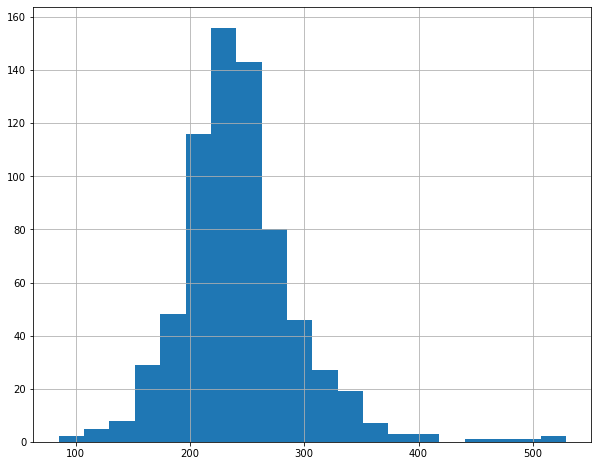

In [753]:
x_train_imputed['Cholesterol'].hist(bins=20)

let's remove the last outliers:

In [754]:
x_train_imputed, y_train_wo_outliers = outlier_removal(pd.concat([x_train_imputed, y_train_wo_outliers], axis=1), ['Cholesterol'])

<AxesSubplot:>

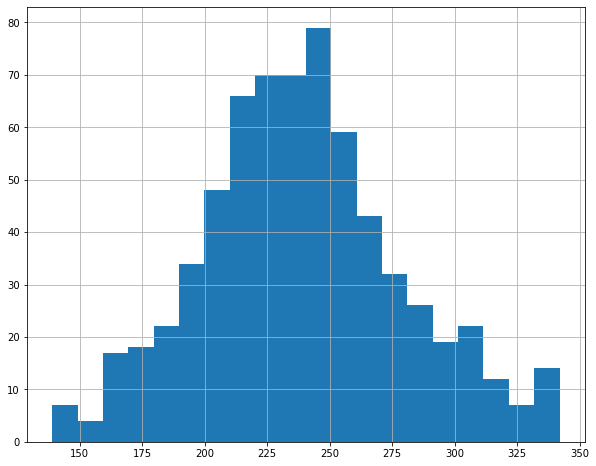

In [755]:
x_train_imputed['Cholesterol'].hist(bins=20)

In [748]:
x_train_imputed.shape

(669, 19)

We need to do one last preprocessing step : scaling the data as we have a wide range of values taken for the different features. This step will ensure that center the data with a mean of zero and a standard deviation of 1. 

### Scaling  features

In [756]:
def scaling_df(X_train, X_test,cat_features):
    num_features = [col for col in X_train.columns if col not in cat_features] #features to rescale
    scaler = StandardScaler()
    
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_features]), columns=num_features, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features, index=X_test.index)
    
    X_train_final = pd.concat([X_train_scaled, X_train[cat_features]], axis=1)
    X_test_final = pd.concat([X_test_scaled, X_test[cat_features]], axis=1)
    
    return X_train_final, X_test_final

# 2. Lasso logistic regression

__Preprocessing step to ensure comparability of feature coefficients : normalization__ Otherwise when analyzing the coefficients we will have coefficients with different order of magnitude without being related to the importance of the feature for the binary classification. 

In [758]:
x_train_preprocessed, x_test_preprocessed=scaling_df(x_train_imputed,x_test_imputed, [])

In [760]:
def logistic_regression(X_train_norm, X_test_norm, y_train):
    logreg = LogisticRegression(penalty='l1', solver='liblinear') #l1 for lasso, only supported by liblinear solver
    logreg.fit(X_train_norm, y_train)
    
    y_pred = logreg.predict(X_test_norm)
    
    cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                            display_labels=['Class 0', 'Class 1'], 
                                            cmap='Blues', 
                                            normalize=None)
    
    print(classification_report(y_test, y_pred))
    print("F1: ",f1_score(y_test, y_pred))
    print("balanced accuracy : ",balanced_accuracy_score(y_test, y_pred))
    
    feature_names = X_train_norm.columns

    plt.figure(figsize=(8, 6)) 
    coefficients = logreg.coef_.flatten()
    y_pos = range(len(feature_names))
    plt.barh(y_pos, coefficients, align='center')
    plt.yticks(y_pos, feature_names)
    plt.xlabel('Coefficient')
    plt.title('Feature Importance')
    plt.tight_layout() 
    plt.show()

              precision    recall  f1-score   support

           0       0.81      0.73      0.77        74
           1       0.83      0.88      0.85       110

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184

F1:  0.8546255506607929
balanced accuracy :  0.8057739557739558


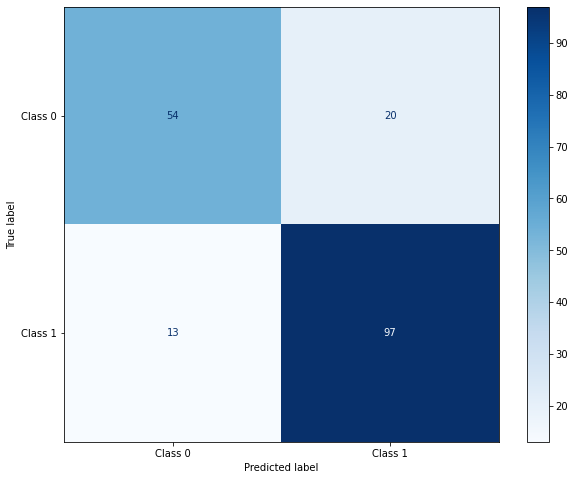

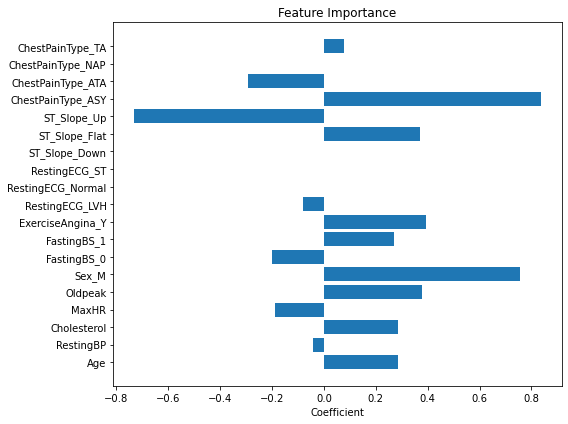

In [761]:
logistic_regression(x_train_preprocessed, x_test_preprocessed, y_train_wo_outliers)

__According to lasso regression, a patient is more likely to have a heart disease if he has an asymptonic chest pain, if he's a man, has exercise angina, a flat ST slope, high Oldpeak, fasting blood sugar, cholesterol and is old. On the other hand, patient are more likely to be healthy if he has a ST slope going down, an atypical angina, low blood sugar and a high maximum heart rate.__ This observations make sense from the medical perspective. 

train a Logistic Regression solely on the important variables determined by the lasso regression: 

              precision    recall  f1-score   support

           0       0.82      0.73      0.77        74
           1       0.83      0.89      0.86       110

    accuracy                           0.83       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.83      0.83      0.82       184

F1:  0.8596491228070176
balanced accuracy :  0.8103194103194102


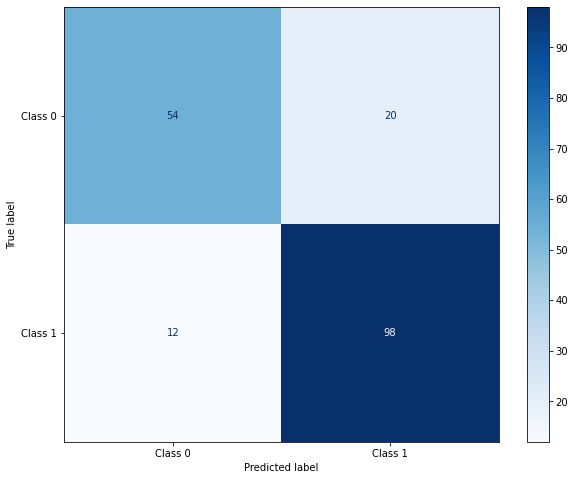

In [876]:
logreg = LogisticRegression() 
logreg.fit(x_train_preprocessed.drop(['ChestPainType_NAP','ST_Slope_Down','RestingECG_ST','RestingECG_Normal','RestingECG_LVH','RestingBP'],axis=1), y_train_wo_outliers)

y_pred = logreg.predict(x_test_preprocessed.drop(['ChestPainType_NAP','ST_Slope_Down','RestingECG_ST','RestingECG_Normal','RestingECG_LVH','RestingBP'],axis=1))

cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        display_labels=['Class 0', 'Class 1'], 
                                        cmap='Blues', 
                                        normalize=None)

print(classification_report(y_test, y_pred))
print("F1: ",f1_score(y_test, y_pred))
print("balanced accuracy : ",balanced_accuracy_score(y_test, y_pred))

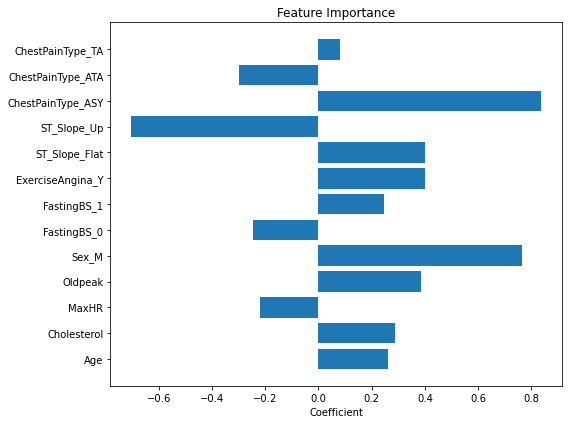

In [877]:
feature_names = x_train_preprocessed.drop(['ChestPainType_NAP','ST_Slope_Down','RestingECG_ST','RestingECG_Normal','RestingECG_LVH','RestingBP'],axis=1).columns

plt.figure(figsize=(8, 6)) 
coefficients = logreg.coef_.flatten()
y_pos = range(len(feature_names))
plt.barh(y_pos, coefficients, align='center')
plt.yticks(y_pos, feature_names)
plt.xlabel('Coefficient')
plt.title('Feature Importance')
plt.tight_layout() 
plt.show()

We can observe that discarding some variables and only keeping the important features highlighted by the previous lasso logistic regression didn't affect the accuracy of the model, on the contrary it has slightly increased : 81% against 80,5%. 

# 3. MLP+SHAP 

## Custom Multi-layer perceptron with Pytorch

In [769]:
class NN(torch.nn.Module):
    def __init__(self,
               input_dimension,
               output_dimension,
               n_hidden_layers,
               hidden_size):

        super().__init__()
        activation=nn.Tanh
        self.fcs=nn.Sequential(*[nn.Linear(input_dimension,hidden_size), activation()])
        self.fch=nn.Sequential(*[nn.Sequential(*[nn.Linear(hidden_size,hidden_size), activation()]) for _ in range(n_hidden_layers-1)])
        self.fce=nn.Linear(hidden_size,output_dimension)
    
    def forward(self, x):
        x=self.fcs(x)
        x=self.fch(x)
        x=self.fce(x)
        x=torch.sigmoid(x)
        return x

    def get_optimizer(self, optimizer_name, params):
        if optimizer_name == "ADAM":
            optimizer=torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
            
        elif optimizer_name == "LBFGS":
            optimizer=torch.optim.LBFGS(params, lr=0.001, max_iter=100, max_eval=None, tolerance_grad=1e-07)
            
        else : raise ValueError("Optimizer not recognized")
        return optimizer


def train(model, optimizer, criterion, inputs, targets):
    def closure():
        loss = 0.0
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        return loss

    optimizer.step(closure)
    return closure().item()

def evaluate(model, x_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(x_test.values.astype(np.float32), dtype=torch.float32)) #.numpy()
    return y_pred



In [770]:
def MLP_pipeline(x_train_1hot,x_test_1hot,y_train,layers,neurons,opt):
    mlp = NN(x_train_1hot.shape[1],1,layers,neurons)
    print(x_train_1hot.shape[0])

    criterion = nn.MSELoss(reduce='none')
    parameters = mlp.parameters()

    optimizer = mlp.get_optimizer(opt,parameters)

    inputs = torch.tensor(x_train_1hot.values.astype(np.float32), dtype=torch.float32, requires_grad=True)
    targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    test_inputs = torch.tensor(x_test_1hot.values.astype(np.float32), dtype=torch.float32, requires_grad=False)
    test_targets = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
    num_epochs = 1500
    for epoch in range(num_epochs):

        loss = train(mlp, optimizer, criterion, inputs, targets)

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')
            
    y_pred= evaluate(mlp,x_test_1hot)
    binarized_predictions= np.where(y_pred >= 0.5, 1, 0)[:,0]
    
    f1 = f1_score(y_test, binarized_predictions)
    print("F1: ",f1)
    balanced_accuracy = balanced_accuracy_score(y_test, binarized_predictions)
    print("balanced accuracy : ",balanced_accuracy)
    
    return mlp

In [766]:
mlp1=MLP_pipeline(x_train_preprocessed,x_test_preprocessed,y_train_wo_outliers,2,40,'ADAM')

669
Epoch [100/1500], Loss: 0.0874
Epoch [200/1500], Loss: 0.0801
Epoch [300/1500], Loss: 0.0693
Epoch [400/1500], Loss: 0.0506
Epoch [500/1500], Loss: 0.0334
Epoch [600/1500], Loss: 0.0251
Epoch [700/1500], Loss: 0.0201
Epoch [800/1500], Loss: 0.0175
Epoch [900/1500], Loss: 0.0170
Epoch [1000/1500], Loss: 0.0168
Epoch [1100/1500], Loss: 0.0167
Epoch [1200/1500], Loss: 0.0166
Epoch [1300/1500], Loss: 0.0166
Epoch [1400/1500], Loss: 0.0166
Epoch [1500/1500], Loss: 0.0165
F1:  0.8073394495412846
balanced accuracy :  0.7648648648648648


## SHAP

In [776]:
def model_wrapper(x):
    x_tensor = torch.from_numpy(x).float().unsqueeze(1)
    return mlp1(x_tensor).detach().numpy()

PermutationExplainer explainer: 670it [00:24, 17.69it/s]                        


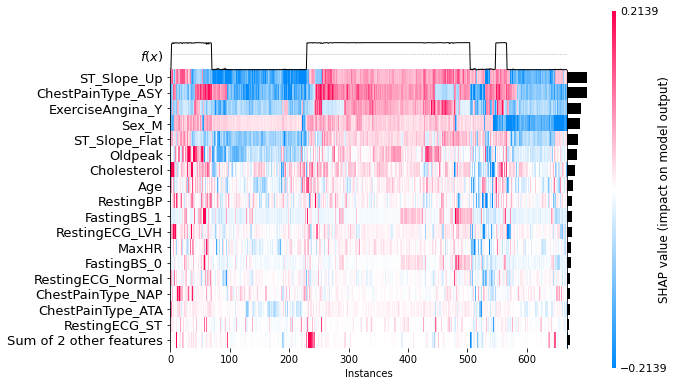

In [778]:
explainer = shap.Explainer(model_wrapper, x_train_preprocessed.values.astype(np.float32))
shap_values = explainer(x_train_preprocessed.astype(np.float32))
shap.plots.heatmap(shap_values, max_display=18)

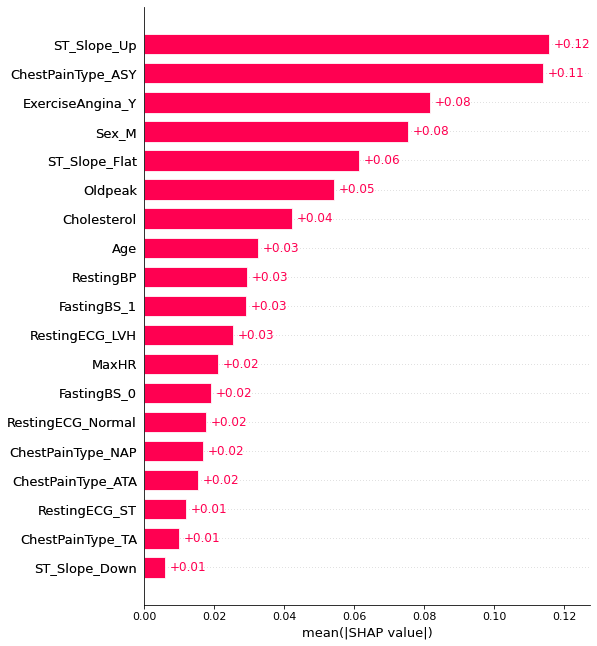

In [779]:
shap.plots.bar(shap_values, max_display=20)

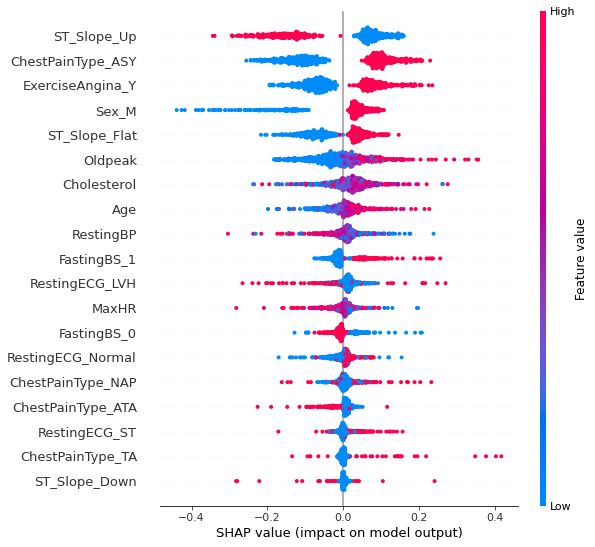

In [780]:
shap.plots.beeswarm(shap_values,  max_display=20)

__As one can see on the bar plot and on the heatmap, the most important features are again the ST Slope, Chest pain type, exercise angina, sex, oldpeak, cholesterol and age. Once again, features influencing the output towards a positive prediction (diseased) are an asymptonic chest pain, an exercise angina, sex being male, a flat ST slope, great oldpeak, cholesterol, age, and fasting blood sugar.__ The shap plots give additional information compared to what the lasso coefficients gave. For example on the beeswarm plot we can see a trend concerning resting blood pressure, with some exceptions. On these plots the shapley explanations seem to be coherent with what we observed with lasso regression, providing more insights on the feature value distributions and their impact on the multilayer perceptron output. 

### visualization of SHAP explanations of two positive and negative samples

In [790]:
positive_examples = x_train_preprocessed[y_train_wo_outliers == 1]
select_2_positives= positive_examples.iloc[0:2,:] 
random_positives = positive_examples.sample(n=2, random_state=0)

negative_examples=x_train_preprocessed[y_train_wo_outliers == 0]
select_2_negatives=negative_examples.iloc[0:2,:] 

In [787]:
select_2_positives

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_Y,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
2,-0.554483,0.503884,-0.628133,-1.129862,0.707688,-1.900998,0.553751,-0.553751,1.242468,-0.502801,0.812434,-0.493452,-0.238479,1.001496,-0.898948,0.995526,-0.521405,-0.556055,-0.224133
7,-1.707802,0.633041,-0.802308,-0.259855,0.707688,0.526040,0.553751,-0.553751,1.242468,-0.502801,0.812434,-0.493452,-0.238479,1.001496,-0.898948,0.995526,-0.521405,-0.556055,-0.224133


In [791]:
select_2_negatives

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_Y,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
0,-1.393260,0.633041,1.238029,1.401066,-0.82383,0.52604,0.553751,-0.553751,-0.80485,-0.502801,0.812434,-0.493452,-0.238479,-0.998506,1.112411,-1.004494,1.917895,-0.556055,-0.224133
1,-1.707802,-0.012742,1.088736,-1.525319,-0.82383,0.52604,0.553751,-0.553751,-0.80485,-0.502801,-1.230869,2.026541,-0.238479,-0.998506,1.112411,-1.004494,1.917895,-0.556055,-0.224133


Let's check that the model predict them as positives and negatives respectively : 

In [794]:
print('model output for positive samples:',model_wrapper(select_2_positives.values.astype(np.float32)))
print('model output for negative samples:',model_wrapper(select_2_negatives.values.astype(np.float32)))

model output for positive samples: [[[0.9912646]]

 [[0.9889003]]]
model output for negative samples: [[[2.3138593e-05]]

 [[3.6049522e-03]]]


The model adequatly predicts the positive samples with probabilities near 1 and near zero for negative samples. Let's compute the shapley values :

In [795]:
e = shap.KernelExplainer(model_wrapper, x_train_preprocessed.values.astype(np.float32))
shap_values_positive = e.shap_values(select_2_positives.astype(np.float32))
shap_values_negative = e.shap_values(select_2_negatives.astype(np.float32))

Using 669 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

__positive samples__

Let's vizualize the explanations given by the shapley values to predict them as positives :

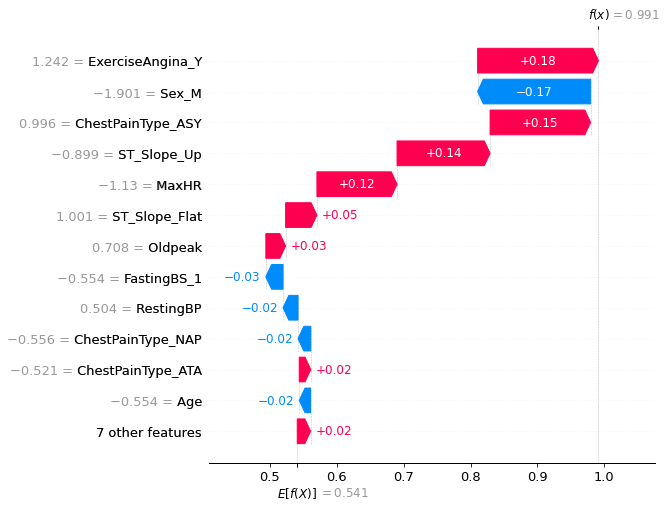

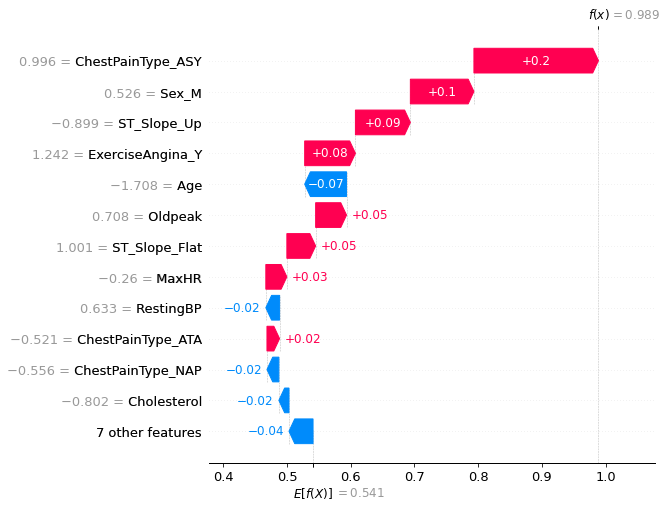

In [796]:
explanation_positive_1 = shap.Explanation(values=shap_values_positive[0][0], data=select_2_positives.iloc[0].values.astype(np.float32),feature_names=select_2_positives.columns.tolist(), base_values = e.expected_value)
explanation_positive_2 = shap.Explanation(values=shap_values_positive[0][1], data=select_2_positives.iloc[1].values.astype(np.float32), feature_names=select_2_positives.columns.tolist(),base_values = e.expected_value)
shap.plots.waterfall(explanation_positive_1, max_display=13)
shap.plots.waterfall(explanation_positive_2, max_display=13)

It is interesting to see how the most important features highlighted earlier explain the predictions. The order of importance of the features however is different. For sample 1 by order of positive contributions : Exercise angina, asymptonic chest pain, ST Slope and max heart rate. For sample 2 : asymptonic chest pain, sex, ST slope, exercise angina, oldpeak. Also, the two individuals are from opposite sex: the first one is a women, which contributes negatively to the positive prediction, whereas the second individual is a man, which contributes positively to the output. The second person is young and has low cholesterol which influence negatively the ouput. 

__negative samples__

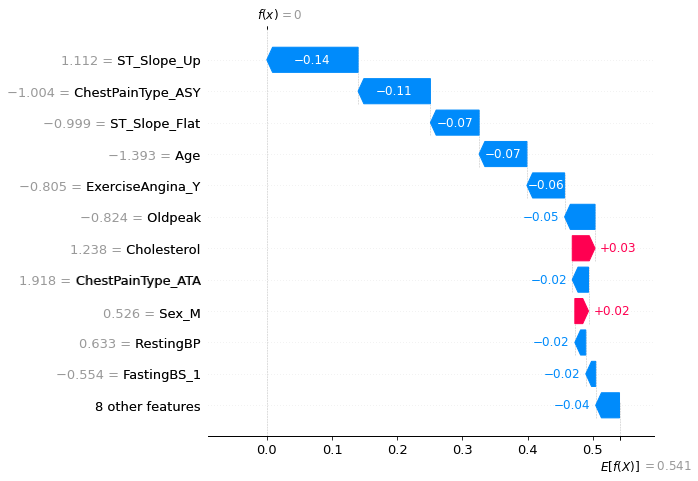

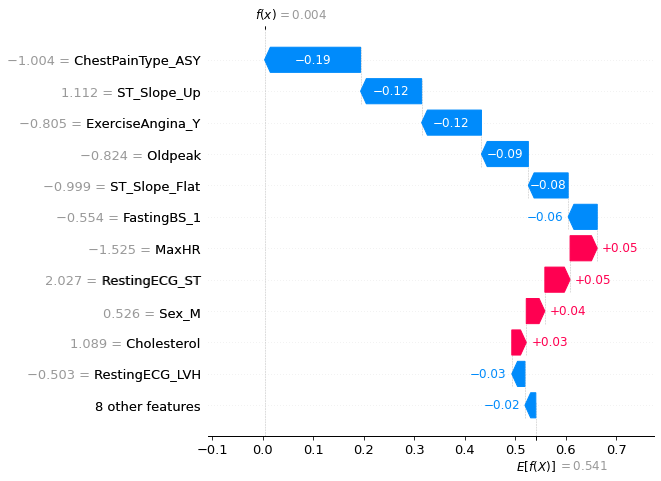

In [797]:
explanation_negative_1 = shap.Explanation(values=shap_values_negative[0][0], data=select_2_negatives.iloc[0].values.astype(np.float32),feature_names=select_2_positives.columns.tolist(), base_values = e.expected_value)
explanation_negative_2 = shap.Explanation(values=shap_values_negative[0][1], data=select_2_negatives.iloc[1].values.astype(np.float32),feature_names=select_2_positives.columns.tolist(), base_values = e.expected_value)

shap.plots.waterfall(explanation_negative_1, max_display=12)
shap.plots.waterfall(explanation_negative_2, max_display=12)

Although the negative samples are men with high cholesterol (and even a ST anomaly resting ECG for the second) which contribute to a positive output, all other factors influence the output negatively : both have a downslopping ST, no asymptonic chest pain, no exercise angina, no flat ST slope, are young, with low oldpeak and low fasting blood sugar. Both predictions are coherent and well explained by the shapley values. 

__For the 4 examples we vizualized, feature importances are consistent across different predictions and compared to overall importance values.__

# 4. NAM : Neural Additive Models

## Custom NAM

In [853]:
class FeatureNN(nn.Module):
    def __init__(self, input_dimension, output_dimension, n_hidden_layers, hidden_size):
        super(FeatureNN, self).__init__()
        activation = nn.Tanh()
        layers = [nn.Linear(input_dimension, hidden_size), activation]
        
        for _ in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)
        
        self.network = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_size, output_dimension)
        
    def forward(self, x):
        x = self.network(x)
        x = self.output_layer(x)
        return x

In [854]:
class NAM(nn.Module):
    def __init__(self, input_dimensions, n_hidden_layers, hidden_size):
        super(NAM, self).__init__()
        # Create a FeatureNN for each input feature
        self.feature_nns = nn.ModuleList([
            FeatureNN(input_dimension=1, output_dimension=1, n_hidden_layers=n_hidden_layers, hidden_size=hidden_size)
            for _ in range(input_dimensions)
        ])
        self.bias = nn.Parameter(torch.zeros(1))  # Model bias
    
    def forward(self, x):
        # Retrieve the ouput of all individual NN, sum and apply sigmoid
        feature_outputs = torch.cat([feature_nn(x[:, i:i+1]) for i, feature_nn in enumerate(self.feature_nns)], dim=1)
        summed = feature_outputs.sum(dim=1, keepdim=True) + self.bias 
        output = torch.sigmoid(summed)
        return output

In [855]:
def train_nam(model, optimizer, criterion, x_train, y_train, epochs):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

def evaluate_nam(model, x_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)
    return y_pred

In [856]:
def NAM_pipeline(X_train,X_test,y_train,layers,neurons):
    
    inputs_out = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32, requires_grad=True)
    targets_out = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    test_inputs_out = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32, requires_grad=False)

    nam_model = NAM(input_dimensions=inputs_out.shape[1], n_hidden_layers=layers, hidden_size=neurons)

    optimizer = torch.optim.Adam(nam_model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss()  # binary classification

    train_nam(nam_model, optimizer, criterion, inputs_out, targets_out, epochs=1500)

    probabilities = evaluate_nam(nam_model, test_inputs_out)
    
    predictions=(probabilities > 0.5).float()
    
    cm = ConfusionMatrixDisplay.from_predictions(y_test, predictions, 
                                            display_labels=['Class 0', 'Class 1'], 
                                            cmap='Blues', 
                                            normalize=None)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)  #probabilities for ROC AUC

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC AUC: {roc_auc}')
    
    return nam_model

Epoch 100/1500, Loss: 0.5417646765708923
Epoch 200/1500, Loss: 0.5376059412956238
Epoch 300/1500, Loss: 0.5358079075813293
Epoch 400/1500, Loss: 0.5352203249931335
Epoch 500/1500, Loss: 0.5341625809669495
Epoch 600/1500, Loss: 0.5339590311050415
Epoch 700/1500, Loss: 0.5327773094177246
Epoch 800/1500, Loss: 0.5327175855636597
Epoch 900/1500, Loss: 0.5326880812644958
Epoch 1000/1500, Loss: 0.5326683521270752
Epoch 1100/1500, Loss: 0.5326537489891052
Epoch 1200/1500, Loss: 0.5326414108276367
Epoch 1300/1500, Loss: 0.5326325297355652
Epoch 1400/1500, Loss: 0.532625675201416
Epoch 1500/1500, Loss: 0.5326200723648071
Accuracy: 0.8586956521739131
Precision: 0.8620689655172413
Recall: 0.9090909090909091
F1 Score: 0.8849557522123893
ROC AUC: 0.8653562653562654


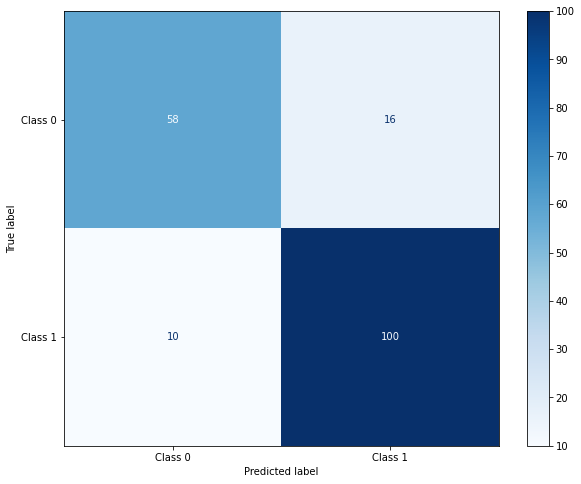

In [857]:
nam_model2=NAM_pipeline(x_train_preprocessed,x_test_preprocessed,y_train_wo_outliers,4,15)

Thanks to the interpretability of NAM we can plot how the output of the NAM varies with different feature values:

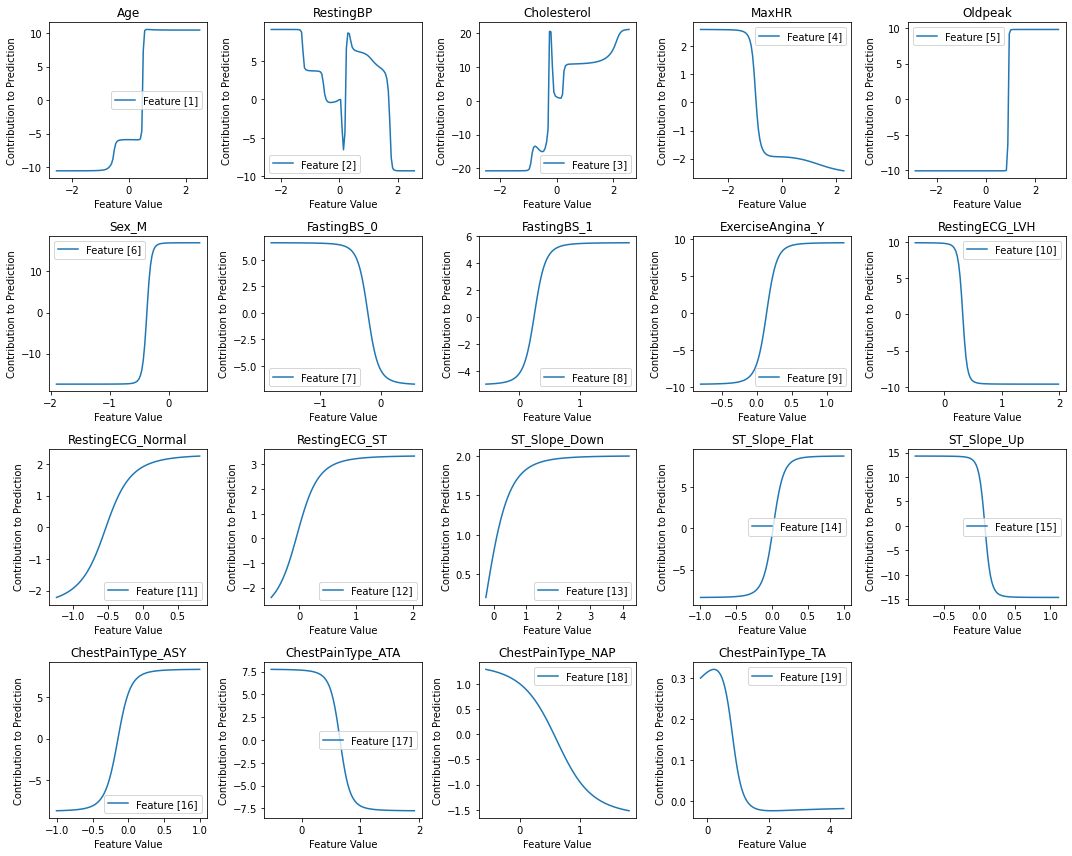

In [874]:
num_points = 100

num_features = len(nam_model2.feature_nns)
num_cols = 5  
num_rows = num_features // num_cols + (num_features % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

if num_features == 1:
    axes = np.array([axes])

axes_flat = axes.flatten()

for i, feature_nn in enumerate(nam_model2.feature_nns):
    feature_min = x_train_preprocessed.iloc[:, i].min() 
    feature_max = x_train_preprocessed.iloc[:, i].max() 
    feature_values = torch.linspace(feature_min, feature_max, steps=num_points).unsqueeze(1)

    with torch.no_grad():
        contributions = feature_nn(feature_values).numpy().flatten()

    ax = axes_flat[i]  
    ax.plot(feature_values.numpy(), contributions, label=f'Feature {[i+1]}')
    ax.set_title(x_train_preprocessed.columns[i])
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('Contribution to Prediction')
    ax.legend()

for ax in axes_flat[num_features:]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()

It is consistent with the previous models : the chest pain type and st slope types that contributes positively to the ouputs are the asymptonic pain and the downslopping and flat ST slope. Being a men, having a high fatsing blood sugar and exercise angina also contributes to positive output. Age,c holesterol and oldpeak also show the same behavior.  

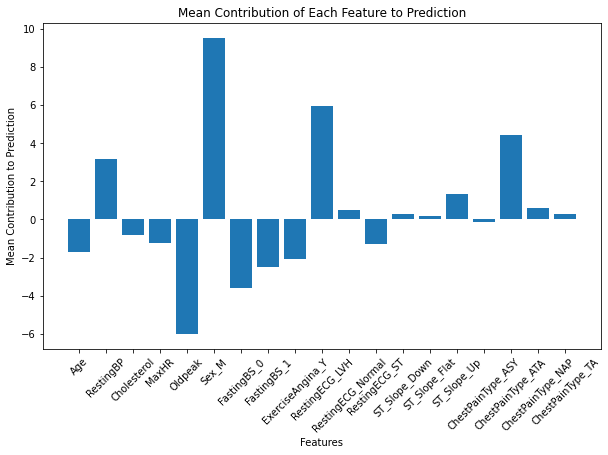

In [875]:
num_features = len(nam_model1.feature_nns)

fig, ax = plt.subplots(figsize=(10, 6))

mean_contributions = []
for i, feature_nn in enumerate(nam_model2.feature_nns):
    with torch.no_grad():
        contributions = feature_nn(torch.tensor(x_train_preprocessed.iloc[:, i].values.astype(np.float32), dtype=torch.float32).unsqueeze(1))
        mean_contribution = torch.mean(contributions)
        mean_contributions.append(mean_contribution.item())

ax.bar(x_train_preprocessed.columns, mean_contributions)
ax.set_xlabel('Features')
ax.set_ylabel('Mean Contribution to Prediction')
ax.set_title('Mean Contribution of Each Feature to Prediction')

plt.xticks(rotation=45)
plt.show()

Again we recognize almost the same important features as before : the sex, whether the chest pain is asymptonic or not, whether there is exercise angina or not, the oldpeak and fasting blood sugar.

In [864]:
random_positives = positive_examples.sample(n=2, random_state=0)
random_positives.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_Y,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
20,-0.973872,1.278824,1.213147,0.53106,2.239205,0.52604,0.553751,-0.553751,1.242468,-0.502801,0.812434,-0.493452,-0.238479,1.001496,-0.898948,-1.004494,1.917895,-0.556055,-0.224133
292,-1.602955,0.310150,0.546331,0.53106,-0.823830,0.52604,-1.805864,1.805864,-0.804850,-0.502801,0.812434,-0.493452,-0.238479,1.001496,-0.898948,0.995526,-0.521405,-0.556055,-0.224133


In [867]:
random_negatives = x_test_preprocessed[y_train_wo_outliers == 0].sample(n=2, random_state=0)
random_negatives.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_Y,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA
11,0.913377,-0.012742,-0.205136,0.372877,1.013991,0.52604,0.553751,-0.553751,-0.80485,-0.502801,0.812434,-0.493452,-0.238479,1.001496,-0.898948,-1.004494,-0.521405,1.798382,-0.224133
72,-0.554483,-0.400212,0.864797,1.163792,-0.313324,0.52604,0.553751,-0.553751,-0.80485,1.988858,-1.230869,-0.493452,-0.238479,1.001496,-0.898948,0.995526,-0.521405,-0.556055,-0.224133


NAM prediction for positive sample 1: tensor([[1.]])
NAM prediction for positive sample 2: tensor([[1.]])
NAM prediction for negative sample 1: tensor([[1.]])
NAM prediction for negative sample 2: tensor([[1.0000]])


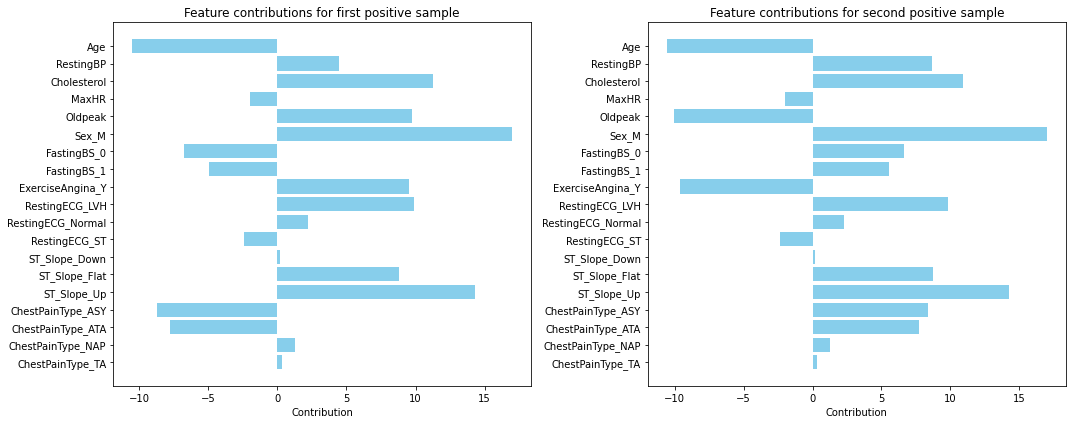

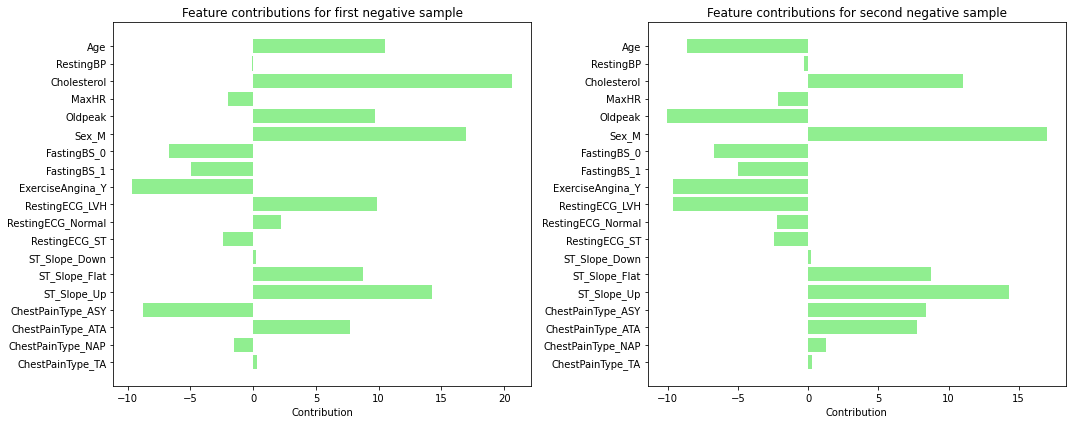

In [873]:
positive_tensor= torch.tensor(random_positives.iloc[0,:].values.astype(np.float32), dtype=torch.float32)
positive_tensor2= torch.tensor(random_positives.iloc[1,:].values.astype(np.float32), dtype=torch.float32)

negative_tensor= torch.tensor(random_negatives.iloc[0,:].values.astype(np.float32), dtype=torch.float32)
negative_tensor2= torch.tensor(random_negatives.iloc[1,:].values.astype(np.float32), dtype=torch.float32)

print('NAM prediction for positive sample 1:',evaluate_nam(nam_model2, positive_tensor.unsqueeze(0)))
print('NAM prediction for positive sample 2:',evaluate_nam(nam_model2, positive_tensor2.unsqueeze(0)))

print('NAM prediction for negative sample 1:',evaluate_nam(nam_model2, negative_tensor.unsqueeze(0)))
print('NAM prediction for negative sample 2:',evaluate_nam(nam_model2, negative_tensor2.unsqueeze(0)))

contributions=[]
contributions2=[]
contributions3=[]
contributions4=[]

for i, feature_nn in enumerate(nam_model2.feature_nns):
    with torch.no_grad():
        contribution = feature_nn(torch.tensor(positive_tensor[i].unsqueeze(0)))
        contributions.append(contribution[0].item())

        contribution2 = feature_nn(torch.tensor(positive_tensor2[i].unsqueeze(0)))
        contributions2.append(contribution2[0].item())
        
        contribution3 = feature_nn(torch.tensor(negative_tensor[i].unsqueeze(0)))
        contributions3.append(contribution3[0].item())

        contribution4 = feature_nn(torch.tensor(negative_tensor2[i].unsqueeze(0)))
        contributions4.append(contribution4[0].item())


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
feature_names = x_train_preprocessed.columns

axes[0].barh(range(len(feature_names)), contributions, align='center', color='skyblue')
axes[0].set_yticks(range(len(feature_names)))
axes[0].set_yticklabels(feature_names)
axes[0].invert_yaxis()  # Reverse the order to have the first feature at the top
axes[0].set_xlabel('Contribution')
axes[0].set_title('Feature contributions for first positive sample')

# Plot contributions for the second sample
axes[1].barh(range(len(feature_names)), contributions2, align='center', color='skyblue')
axes[1].set_yticks(range(len(feature_names)))
axes[1].set_yticklabels(feature_names)
axes[1].invert_yaxis()  # Reverse the order to have the first feature at the top
axes[1].set_xlabel('Contribution')
axes[1].set_title('Feature contributions for second positive sample')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
feature_names = x_train_preprocessed.columns

axes[0].barh(range(len(feature_names)), contributions3, align='center', color='lightgreen')
axes[0].set_yticks(range(len(feature_names)))
axes[0].set_yticklabels(feature_names)
axes[0].invert_yaxis()  # Reverse the order to have the first feature at the top
axes[0].set_xlabel('Contribution')
axes[0].set_title('Feature contributions for first negative sample')

# Plot contributions for the second sample
axes[1].barh(range(len(feature_names)), contributions4, align='center', color='lightgreen')
axes[1].set_yticks(range(len(feature_names)))
axes[1].set_yticklabels(feature_names)
axes[1].invert_yaxis()  # Reverse the order to have the first feature at the top
axes[1].set_xlabel('Contribution')
axes[1].set_title('Feature contributions for second negative sample')
plt.tight_layout()
plt.show()

This NAM visuzalization where we plot the output of each feature-specific network is very useful to confirm that the explanations are based on the same reasons than with the previous methods. Features contributing to a positive output are: asymptonic chest pain(second positive and negative samples), flat ST slope and male sex (all 4 samples), exercise angina (first positive sample), high fasting blood sugar (second positive sample), great age(first positive sample) oldpeak (first samples) and cholesterol. 

In summary, the three methods implemented performed with similarly high accuracy (around 80%) while providing explanations at different degrees. Explanations were provided by clear plots and were meaningful in the medical context of the disease. 